In [1]:
import nbimporter
from extract_digits import load_image, threshold_img, find_center_3by3_square, find_all_squares, extract_digit_images, plot_all_squares, plot_center_3by3
from solve_sodoku import SodokuField
from recognize_digits import DigitPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt

Importing Jupyter notebook from extract_digits.ipynb
Importing Jupyter notebook from solve_sodoku.ipynb
Importing Jupyter notebook from recognize_digits.ipynb


Using TensorFlow backend.


In [102]:
def try_except(try_fn, except_fn=None):
    try:
        return True, try_fn()
    except:
        return False, (except_fn() if except_fn else None)


def copy_image(src, dest, dest_topleft):
    dest_channels = dest.shape[2]
    
    if len(src.shape) == 2:
        src_rows, src_cols = src.shape
        new_src = np.zeros((src_rows, src_cols, dest_channels))
        for i in range(dest_channels):
            new_src[:, :, i] = src
        src = new_src
    else:
        src_rows, src_cols, src_channels = src.shape
        assert src_channels == dest_channels

    dest_top, dest_left = dest_topleft
    dest[dest_top:dest_top+src_rows, dest_left:dest_left+src_cols, :] = src
    return dest

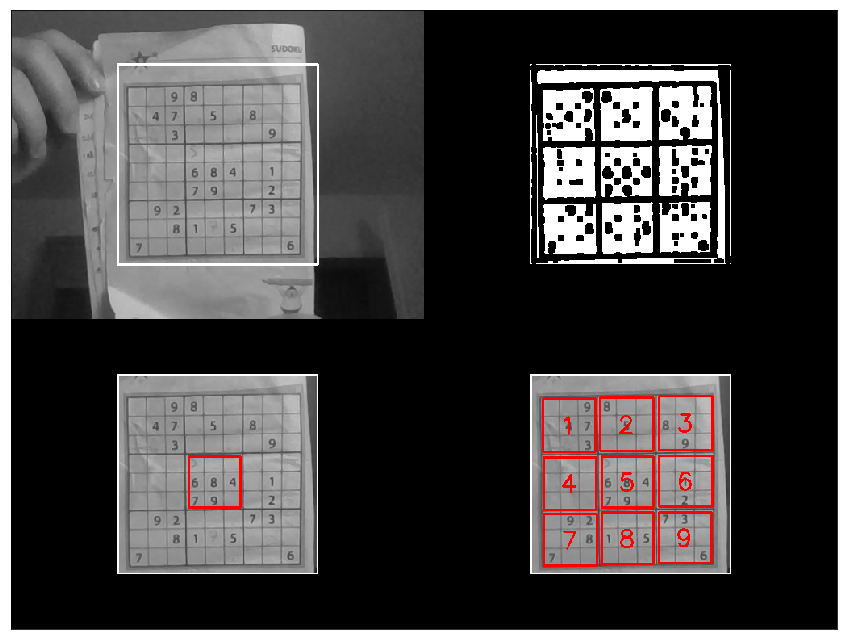

In [103]:
cap = cv2.VideoCapture(0)

try:
    success = False
    while True:
        ret, frame = cap.read()

        res = load_image(frame)
        orig = res['img'].copy()
        rows, cols = orig.shape
        
        half_target_size = int(min(rows, cols) * 0.325)
        target_top = int(rows / 2 - half_target_size)
        target_bot = int(rows / 2 + half_target_size)
        target_left = int(cols / 2 - half_target_size)
        target_right = int(cols / 2 + half_target_size)
        
        cv2.rectangle(orig, (target_left, target_top), (target_right, target_bot), (255, 0, 0), 2)
        res['img'] = orig[target_top:target_bot, target_left:target_right]
        
        final = np.zeros((rows * 2, cols * 2, 3))
        copy_image(orig, final, (0, 0))
        
        res = threshold_img(res)
        copy_image(res['bin'], final, (target_top, target_left + cols))
        
        ok, res = try_except(lambda: find_center_3by3_square(res))
        
        if ok:
            copy_image(plot_center_3by3(res, None), final, (target_top + rows, target_left))
            ok, res = try_except(lambda: find_all_squares(res))
        
        if ok:
            copy_image(plot_all_squares(res, None), final, (target_top + rows, target_left + cols))
            ok, res = try_except(lambda: extract_digit_images(res))
        
        # Display the resulting frame (horizontal mirror to make interaction easier)
        cv2.imshow('frame', final.astype(np.uint8)[:, ::-1, :])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
        # check if squares are reasonable
        if ok and 'squares' in res:
            success = True  # let's be optimists
            
            # exactly 9 squares
            if len(res['squares']) != 9:
                success = False
            
            # longest side must be less than 1/3 of picture
            max_side = max(max((bx - ax), (by - ay)) for ax, ay, bx, by in res['squares'])
            if max_side > 2 * half_target_size / 3:
                success = False
            
            # shortest side must be more than 1/5 of the picture
            min_side = min(min((bx - ax), (by - ay)) for ax, ay, bx, by in res['squares'])
            if min_side < 2 * half_target_size / 4:
                success = False
            
            # smallest area / largest area > 0.92
            areas = [(bx - ax) * (by - ay) for ax, ay, bx, by in res['squares']]
            if min(areas) / max(areas) < 0.9:
                success = False
            
            if success:
                break
    
    plt.figure(figsize=(12, 9))
    plt.imshow(final.astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    
finally:
    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()

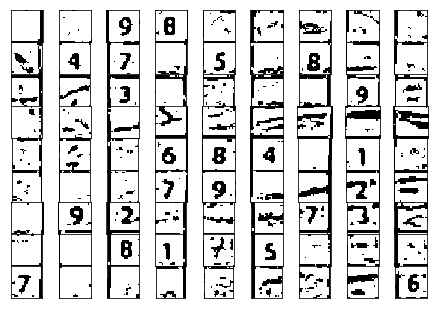

In [96]:
res = extract_digit_images(res)

for i, digit in enumerate(res['digits']):
    plt.subplot(9, 9, i + 1)
    plt.imshow(digit['img'], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
plt.show()

In [97]:
preds = DigitPredictor().predict_digits([digit['img'] for digit in res['digits']], return_proba=True)
digits = [x if x > 0 else None for x in np.argmax(preds, axis=1)]

In [99]:
sodoku = SodokuField(digits)
sodoku.pretty_print()

+---------+---------+---------+
|       9 | 8       | 7       |
|    4  7 |    5    | 8       |
|    4  3 |         |    9  7 |
+---------+---------+---------+
|         | 5     7 | 7  7  7 |
|         | 6  8  4 |    1    |
|         | 7  9    | 4  2  7 |
+---------+---------+---------+
|    9  3 |         | 7  3  2 |
|       8 | 1  7  5 |         |
| 7       |       7 |    7  6 |
+---------+---------+---------+



In [101]:
solved, _ = sodoku.brute_force()
sodoku.pretty_print()
solved

+---------+---------+---------+
|       9 | 8       | 7       |
|    4  7 |    5    | 8       |
|    4  3 |         |    9  7 |
+---------+---------+---------+
|         | 5     7 | 7  7  7 |
|         | 6  8  4 |    1    |
|         | 7  9    | 4  2  7 |
+---------+---------+---------+
|    9  3 |         | 7  3  2 |
|       8 | 1  7  5 |         |
| 7       |       7 |    7  6 |
+---------+---------+---------+



False